In [2]:
import pandas as pd
from datetime import datetime
import math
from pymongo import MongoClient

class ClickThrough:
    def __init__(self):
        self.total_distance = 0
        self.user_click_counts = {}

        self.average_dist = []

        self.hit_click = 0
        self.total_click = 0

        self.client = MongoClient("mongodb://localhost:27017")
        self.db = self.client["INTUX"]

        gaze_data = list(self.db["GazeData"].find())
        click_data = list(self.db["ClickData"].find())
        meta_data = list(self.db["MetaData"].find())

        self.gaze_df = pd.DataFrame(gaze_data)
        self.click_df = pd.DataFrame(click_data)
        self.meta_df = pd.DataFrame(meta_data)
    
    def preprocess(self):
        self.gaze_df = self.gaze_df.drop(['_id'],axis=1)
        self.click_df = self.click_df.drop(['_id'],axis=1)
        self.meta_df = self.meta_df.drop(['_id'],axis=1)


    def calculate_distance(self,x1, y1, x2, y2):
        return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

    def analyze_clicks_gaze(self,gaze_data, click_data):
        total_count = 0

        for index,click in click_data.iterrows():
            click_time = click['normalizedTimestamp']
            click_x = click['x']
            click_y = click['y']

            min_timestamp = click_time - 1000  # 1 second before click in milliseconds
            max_timestamp = click_time + 1000  # 1 second after click in milliseconds

            user_gaze = []

            distance_sum = 0
            count = 0

            for i,g in gaze_data.iterrows():

                if g["normalizedTimestamp"] >= min_timestamp and g["normalizedTimestamp"] <= max_timestamp:
                    
                    euclid_dist = self.calculate_distance(g["x"], g["y"], click_x, click_y)

                    distance_sum += euclid_dist
                    count+=1
                    
                    if euclid_dist <= 100: # adjust the error in pixels here
                        user_gaze.append(euclid_dist)
            
            self.average_dist.append(distance_sum/count)

            if user_gaze:
                total_count += 1
        
        return total_count

    def Analyse(self):
        for _, gaze_entry in self.meta_df.iterrows():
            roll_no = gaze_entry["rollNo"]
            if roll_no not in self.user_click_counts:
                self.user_click_counts[roll_no] = {"total_clicks": 0, "clicks_when_looking": 0}

        for roll_no, click_count in self.user_click_counts.items():
            selected_row = self.meta_df[self.meta_df['rollNo'] == roll_no]
            click_count["total_clicks"] = selected_row['clickCount'].values[0]

            gaze_roll = self.gaze_df[self.gaze_df['rollNo'] == roll_no]
            click_roll = self.click_df[self.click_df['rollNo'] == roll_no]

            click_count["clicks_when_looking"] = self.analyze_clicks_gaze(gaze_roll,click_roll)


        for roll_no, click_count in self.user_click_counts.items():
            self.hit_click+=click_count['clicks_when_looking']
            self.total_click+=click_count['total_clicks']

            print(f"User {roll_no}: {click_count['clicks_when_looking']} clicks out of {click_count['total_clicks']} were clicked when the user was looking at it.")

        print("Hit ratio",self.hit_click,self.total_click,self.hit_click/self.total_click)

        print("Total average distance between clicks and gaze at the time of click is:",sum(self.average_dist)/len(self.average_dist))


def main():
    clickThrough = ClickThrough()
    clickThrough.Analyse()


if __name__ == "__main__":
    main()


User CB.EN.U4EEE23137: 13 clicks out of 15 were clicked when the user was looking at it.
User CB.EN.U4CSE21023: 8 clicks out of 11 were clicked when the user was looking at it.
User CB.EN.U4CSE21060: 16 clicks out of 20 were clicked when the user was looking at it.
User CB.EN.U4CSE22356: 15 clicks out of 17 were clicked when the user was looking at it.
User CB.EN.U4CSE20436: 14 clicks out of 16 were clicked when the user was looking at it.
User CB.EN.U4CSE22304: 9 clicks out of 14 were clicked when the user was looking at it.
User CB.EN.U4CSE21050: 9 clicks out of 11 were clicked when the user was looking at it.
User CB.EN.U4EEE23044: 8 clicks out of 12 were clicked when the user was looking at it.
User CB.EN.U4CSE22011: 7 clicks out of 15 were clicked when the user was looking at it.
User CB.EN.U4CSE20403: 26 clicks out of 30 were clicked when the user was looking at it.
User CB.EN.U4CSE21002: 9 clicks out of 14 were clicked when the user was looking at it.
User CB.EN.U4CSE22308: 15 c

In [7]:
# Install pyGazeAnalyser using pip
!pip install pygazeanalyser

# import numpy as np
# import matplotlib.pyplot as plt
# from pygazeanalyser.edfreader import read_edf

# # Load eye-tracking data from an EDF file
# filename = 'path/to/your/eye_tracking_data.edf'
# data = read_edf(filename, 'fixations')

# # Extract relevant information from the eye-tracking data
# timestamps = data['events']['fixations']['start']
# x_positions = data['events']['fixations']['positionX']
# y_positions = data['events']['fixations']['positionY']
# durations = data['events']['fixations']['duration']

# # Create a basic gaze plot
# plt.figure(figsize=(10, 6))
# plt.scatter(x_positions, y_positions, c=durations, cmap='viridis', s=100)
# plt.colorbar(label='Fixation Duration (ms)')
# plt.title('Gaze Plot')
# plt.xlabel('X Position')
# plt.ylabel('Y Position')
# plt.show()

ERROR: Could not find a version that satisfies the requirement pygazeanalyser (from versions: none)
ERROR: No matching distribution found for pygazeanalyser

[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: C:\Users\prade\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
from sklearn.cluster import DBSCAN
import numpy as np
import matplotlib.pyplot as plt
from pymongo import MongoClient
import pandas as pd

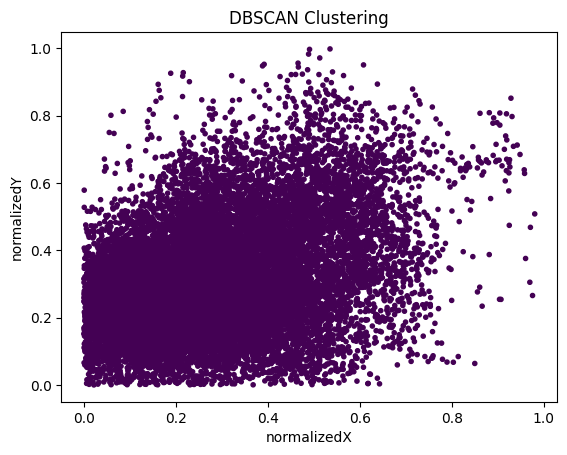

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

client = MongoClient("mongodb://localhost:27017")
db = client["INTUX"]

gaze_data = list(db["GazeData"].find())

# Load the DataFrame from a CSV file
df = pd.DataFrame(gaze_data)  # Replace 'your_file.csv' with the actual file path

df = df[(df['normalizedX'] > 0) & (df['normalizedX'] < 1)]
df = df[(df['normalizedY'] > 0) & (df['normalizedY'] < 1)]


# Extract the 'normalizedX' and 'normalizedY' columns
X = df[['normalizedX', 'normalizedY']].values

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.000003, min_samples=5)
labels = dbscan.fit_predict(X)

# Plot the original data and the clusters
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='.')
plt.title('DBSCAN Clustering')
plt.xlabel('normalizedX')
plt.ylabel('normalizedY')
plt.show()


C:\Users\prade\AppData\Local\Temp\ipykernel_18776\3604251281.py:29: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  k = kde.gaussian_kde(X.T)


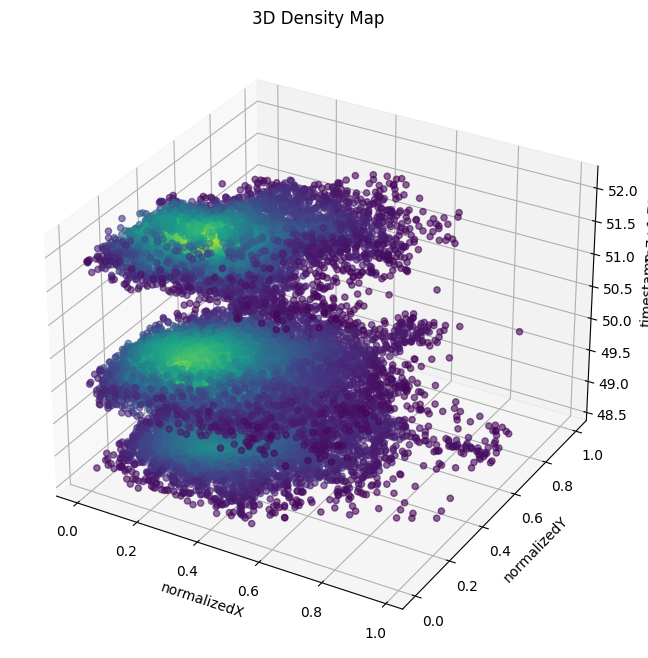

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from pymongo import MongoClient
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import kde

# Assume you have established a connection to your MongoDB
client = MongoClient("mongodb://localhost:27017")
db = client["INTUX"]

# Fetch data from MongoDB
gaze_data = list(db["GazeData"].find())

# Load the DataFrame from MongoDB
df = pd.DataFrame(gaze_data)

df = df[(df['normalizedX'] > 0) & (df['normalizedX'] < 1)]
df = df[(df['normalizedY'] > 0) & (df['normalizedY'] < 1)]


# Extract the 'normalizedX', 'normalizedY', and 'time' columns
X = df[['normalizedX', 'normalizedY', 'timestamp']]

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create a 3D kernel density estimate
k = kde.gaussian_kde(X.T)
density = k(X.T)

# Plot the 3D density
ax.scatter(X['normalizedX'], X['normalizedY'], X['timestamp'], c=density, cmap='viridis', marker='o', s=20, alpha=0.6)

ax.set_xlabel('normalizedX')
ax.set_ylabel('normalizedY')
ax.set_zlabel('timestamp')

plt.title('3D Density Map')
plt.show()


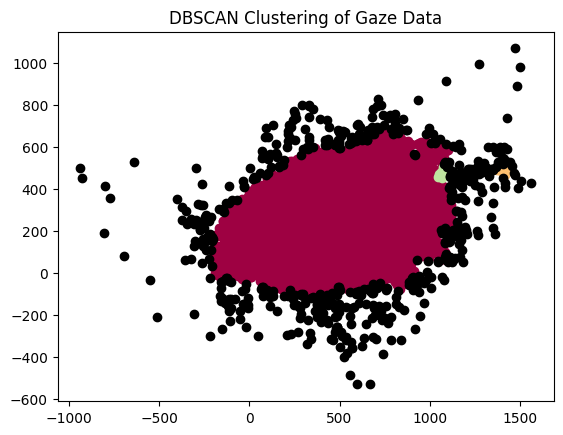

In [14]:
client = MongoClient("mongodb://localhost:27017")
db = client["INTUX"]

gaze_data = list(db["GazeData"].find())
click_data = list(db["ClickData"].find())
meta_data = list(db["MetaData"].find())

gaze_df = pd.DataFrame(gaze_data)
click_df = pd.DataFrame(click_data)
meta_df = pd.DataFrame(meta_data)

gaze_points = gaze_df[['x', 'y']].values

# Apply DBSCAN
dbscan = DBSCAN(eps=30, min_samples=10)
labels = dbscan.fit_predict(gaze_points)

# Visualize the clusters
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Noise points
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = gaze_points[class_member_mask]
    plt.scatter(xy[:, 0], xy[:, 1], c=[col], marker='o')

plt.title('DBSCAN Clustering of Gaze Data')
plt.show()
